# DS Automation Assignment

Using our prepared churn data from week 2:
- use pycaret to find an ML algorithm that performs best on the data
    - Choose a metric you think is best to use for finding the best model; by default, it is accuracy but it could be AUC, precision, recall, etc. The week 3 FTE has some information on these different metrics.
- save the model to disk
- create a Python script/file/module with a function that takes a pandas dataframe as an input and returns the probability of churn for each row in the dataframe
    - your Python file/function should print out the predictions for new data (new_churn_data.csv)
    - the true values for the new data are [1, 0, 0, 1, 0] if you're interested
- test your Python module and function with the new data, new_churn_data.csv
- write a short summary of the process and results at the end of this notebook
- upload this Jupyter Notebook and Python file to a Github repository, and turn in a link to the repository in the week 5 assignment dropbox

## Load data

First, we are going to load our same prepared data from week 2 where everything has been converted to numbers. Many autoML packages can handle non-numeric data (they usually convert it to numeric with various methods).

In [35]:
import pandas as pd

df = pd.read_csv('prepped_churn_data.csv')
df = df.drop('Unnamed: 0', axis=1)
df

,tenure,PhoneService,Contract,MonthlyCharges,TotalCharges,Churn,Credit card (automatic),Electronic check,Mailed check,Total_tenure_ratio
0,1,0,0,29.85,29.85,0,0,1,0,29.850000
1,34,1,1,56.95,1889.50,0,0,0,1,55.573529
2,2,1,0,53.85,108.15,1,0,0,1,54.075000
3,45,0,1,42.30,1840.75,0,0,0,0,40.905556
4,2,1,0,70.70,151.65,1,0,1,0,75.825000
...,...,...,...,...,...,...,...,...,...,...
7038,24,1,1,84.80,1990.50,0,0,0,1,82.937500
7039,72,1,1,103.20,7362.90,0,1,0,0,102.262500
7040,11,0,0,29.60,346.45,0,0,1,0,31.495455
7041,4,1,0,74.40,306.60,1,0,0,1,76.650000


# AutoML with pycaret

Our next step is to use pycaret for autoML. 


Install pycaret

* pip install pycaret


Then we can import the functions we need:

In [36]:
from pycaret.classification import ClassificationExperiment #setup, compare_models, predict_model, save_model, load_model

In [37]:
automl = ClassificationExperiment() #setup(df, target='Churn')

In [38]:
automl.setup(df, target='Churn')

,Description,Value
0,Session id,6640
1,Target,Churn
2,Target type,Binary
3,Original data shape,"(7043, 10)"
4,Transformed data shape,"(7043, 10)"
5,Transformed train set shape,"(4930, 10)"
6,Transformed test set shape,"(2113, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


This will ask us to check if the datatypes of the input data are correct. In this case, they seem fine. There are a huge number of parameters we can set that we can see in the [docs](https://pycaret.org/classification/) or if we run `?setup` in a cell. For now, we are leaving everything else at the default. However, relating it to last week, we can see there is a feature_selection option we could set.


In [39]:
automl

Next up, we simply run the autoML to find the best model:

In [40]:
best_model = automl.compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:28:46
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7931,0.8350,0.5184,0.6360,0.5701,0.4360,0.4406,4.2510
gbc,Gradient Boosting Classifier,0.7897,0.8355,0.4825,0.6378,0.5486,0.4151,0.4224,0.7450
ada,Ada Boost Classifier,0.7888,0.8330,0.5039,0.6301,0.5587,0.4223,0.4277,0.2880
lda,Linear Discriminant Analysis,0.7864,0.8234,0.4894,0.6267,0.5480,0.4113,0.4175,0.0640
ridge,Ridge Classifier,0.7862,0.0000,0.4244,0.6507,0.5120,0.3832,0.3984,0.0400
lightgbm,Light Gradient Boosting Machine,0.7828,0.8252,0.4939,0.6132,0.5465,0.4060,0.4104,0.4320
rf,Random Forest Classifier,0.7720,0.8056,0.4756,0.5881,0.5250,0.3774,0.3816,0.7740
knn,K Neighbors Classifier,0.7653,0.7432,0.4572,0.5721,0.5077,0.3564,0.3605,0.0800
et,Extra Trees Classifier,0.7602,0.7847,0.4817,0.5571,0.5155,0.3576,0.3599,0.5200
qda,Quadratic Discriminant Analysis,0.7471,0.8260,0.7317,0.5177,0.6057,0.4278,0.4422,0.0390


Within the notebook, this updates in real time as it's fitting. We can see the boosting algorithms like xgboost and catboost take the longest to run. Often xgboost will be near the top. To get xgboost and lightgbm working, we either need to allow preprocessing (which converts categorical columns into numeric columns).

Our best_model object now holds the highest-scoring model. We can also set an argument `sort` in `compare_models` to choose another metric as our scoring metric. By default, it uses accuracy (and we can see the table above is sorted by accuracy). We could set this to `sort='Precision'` to use precision (TP / (TP + FN)), for example.

In [41]:
best_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=6640, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

We can now plot a variety of information about the best model:

In [42]:
automl.evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

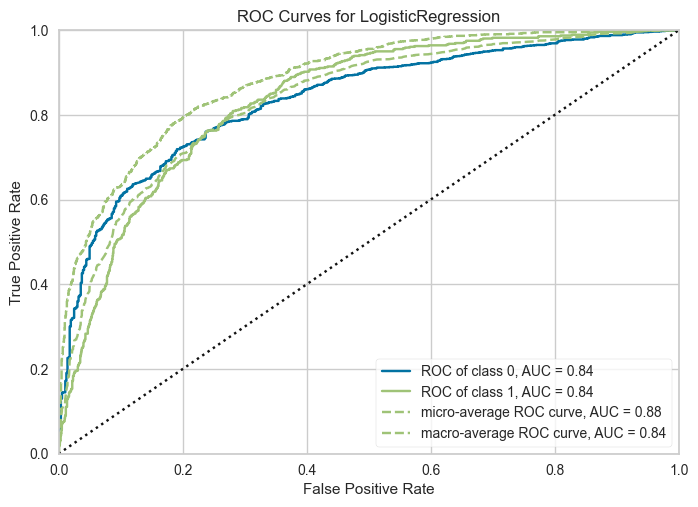

In [43]:
automl.plot_model(best_model)

It looks like our best model is LogisticRegression, closely followed by some others. This may change when you re-run this - there is some randomness built in that we are not fixing (e.g. for the cross-validation splits possibly), so the top model may be different each time this is run since the accuracy scores are so similar between models.

PyCaret can also plot a confusion matrix for us:

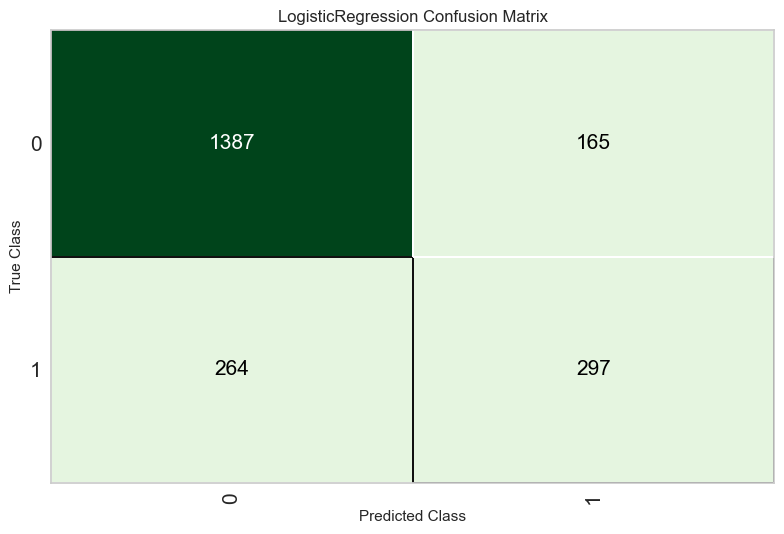

In [44]:
automl.plot_model(best_model, plot = 'confusion_matrix')

We can now make predictions. For example, we can make predictions on the last row:

In [46]:
df.iloc[-2:-1].shape

(1, 10)

We are selecting the last row, but using the indexing `[-2:-1]` to make it a 2D array instead of 1D (which throws an error). Try running `df.iloc[-1].shape` and `df.iloc[-2:-1].shape` to see how they differ.

We can use pycaret's predict_model function with the row above:

In [47]:
df.iloc[-2].shape

(10,)

In [48]:
automl.predict_model(best_model, df.iloc[-2:-1])

,tenure,PhoneService,Contract,MonthlyCharges,TotalCharges,Credit card (automatic),Electronic check,Mailed check,Total_tenure_ratio,Churn,prediction_label,prediction_score
7041,4,1,0,74.400002,306.600006,0,0,1,76.650002,1,0,0.5063


We can see this creates a new column, 'Score', with the probability of class 1. It also creates a 'Label' column with the predicted label, where it rounds up if score is >= 0.5 (greater than or equal to 0.5).

We can also do predictions for the whole dataset:

In [57]:
predictions = automl.predict_model(best_model, data=df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7938,0.8367,0.5217,0.6360,0.5732,0.4390,0.4428


In [50]:
predictions.head()

,tenure,PhoneService,Contract,MonthlyCharges,TotalCharges,Credit card (automatic),Electronic check,Mailed check,Total_tenure_ratio,Churn,prediction_label,prediction_score
0,1,0,0,29.850000,29.850000,0,1,0,29.850000,0,1,0.5867
1,34,1,1,56.950001,1889.500000,0,0,1,55.573528,0,0,0.9461
2,2,1,0,53.849998,108.150002,0,0,1,54.075001,1,0,0.6236
3,45,0,1,42.299999,1840.750000,0,0,0,40.905556,0,0,0.9371
4,2,1,0,70.699997,151.649994,0,1,0,75.824997,1,1,0.6274


## Saving and loading our model

Next, we want to save our trained model so we can use it in a Python file later. pycaret has a handy function for this, which saves the model as a pickle file:

In [51]:
automl.save_model(best_model, 'pycaret_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['tenure', 'PhoneService',
                                              'Contract', 'MonthlyCharges',
                                              'TotalCharges',
                                              'Credit card (automatic)',
                                              'Electronic check', 'Mailed check',
                                              'Total_tenure_ratio'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,...
                  TransformerWrapper(exclude=None, include=None,
                                     tra

`pickle` is a built-in module in the Python standard library which allows for saving and loading of binary data. It's data that's been encoded (usually using hexidecimal encoding) to a file, and we can store any Python object as-is in a pickle file. Then we can load the data from the file and be right back where we left off. 

Once we have our saved pycaret model, we can test loading it and making predictions to make sure it works:

In [52]:
new_pycaret = ClassificationExperiment()
loaded_model = new_pycaret.load_model('pycaret_model')

Transformation Pipeline and Model Successfully Loaded


In [53]:
new_data = df.iloc[-2:-1]

In [54]:
new_pycaret.predict_model(loaded_model, new_data)

,tenure,PhoneService,Contract,MonthlyCharges,TotalCharges,Credit card (automatic),Electronic check,Mailed check,Total_tenure_ratio,Churn,prediction_label,prediction_score
7041,4,1,0,74.400002,306.600006,0,0,1,76.650002,1,0,0.5063


# Making a Python module to make predictions

We can now use this model in a Python file to take in new data and make a prediction. We will first need to compose a Python file. We can do this in many ways:

- Jupyter and Jupyter Lab
- VS Code
- Atom
- Notepad++
- Other text editors or IDEs (integrated development environments)


The file we've created is show below:

In [55]:
from IPython.display import Code

Code('predict_churn.py')

import pandas as pd
from pycaret.classification import ClassificationExperiment

def load_data(filepath):
    """
    Loads Churn data into a DataFrame from a string filepath.
    """
    df = pd.read_csv(filepath)
    return df


def make_predictions(df):
    """
    Uses the pycaret best model to make predictions on data in the df dataframe.
    """
    classifier = ClassificationExperiment()
    model = classifier.load_model('pycaret_model')
    predictions = classifier.predict_model(model, data=df)
    #predictions.rename({'Label': 'Churn_prediction'}, axis=1, inplace=True)
    #predictions['Churn_prediction'].replace({1: 'Churn', 0: 'Not Churn '},inplace=True)
    return predictions #['Churn_prediction']


if __name__ == "__main__":
    df = load_data('prepped_churn_data.csv')
    predictions = make_predictions(df)
    print('predictions:')
    print(predictions)

We can test out running the file with the Jupyter "magic" command %run:

In [56]:
%run predict_churn.py

Transformation Pipeline and Model Successfully Loaded
predictions:
      Unnamed: 0  tenure  PhoneService  Contract  MonthlyCharges  \
0              0       1             0         0       29.850000   
1              1      34             1         1       56.950001   
2              2       2             1         0       53.849998   
3              3      45             0         1       42.299999   
4              4       2             1         0       70.699997   
...          ...     ...           ...       ...             ...   
7038        7038      24             1         1       84.800003   
7039        7039      72             1         1      103.199997   
7040        7040      11             0         0       29.600000   
7041        7041       4             1         0       74.400002   
7042        7042      66             1         2      105.650002   

      TotalCharges  Credit card (automatic)  Electronic check  Mailed check  \
0        29.850000                   

<Figure size 800x550 with 0 Axes>

# Summary

PyCaret, an AutoML library, to analyze and predict customer churn. It starts with data loading and preprocessing, followed by installation and setup of PyCaret. And found Logistic Regression as the best model with "contract" as a key feature.

* Data Loading: We began by loading our preprocessed dataset from week 2, where everything had already been converted into numeric format.

- PyCaret Setup: We proceeded to set up PyCaret, an AutoML library, to automate various tasks. This included installing it and configuring it to work with our dataset. PyCaret streamlines processes like data preprocessing and offers numerous customization options.

- Model Comparison: Next, we utilized PyCaret to compare several machine learning models, aiming to identify the best-performing one for our churn prediction task. 

- Model Evaluation: We conducted a comprehensive evaluation of the top model, including generating visualizations and examining metrics like accuracy. This in-depth assessment provided a clear understanding of the model's performance.

- Making Predictions: We demonstrated how to make predictions using the trained model. This capability allows us to predict churn on new data, a crucial functionality for our analysis.

- Model Saving and Loading: To ensure future usability, we explored how to save the best model as a pickle file. This step is vital for potential model deployment.

- Creating a Python Module: Finally, we suggested creating a Python module for efficient model deployment across different environments. This approach enhances the versatility of our churn prediction model.